# Imports

In [1]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
from sklearn import datasets
import math

# Dataset

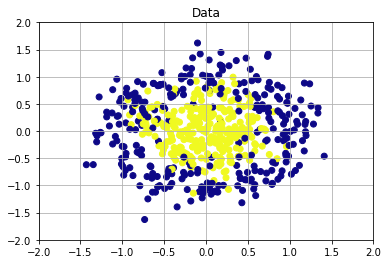

In [2]:
X,Y = datasets.make_circles(n_samples=576, shuffle=True, noise=0.25, random_state=None, factor=0.4)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='plasma')
plt.grid()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title('Data')
plt.show()

# MLP Implementation

In [3]:
# Q2_graded

import math
class MLP:
    def __init__(self, lr = 0.01, hidden_layers = [3]):
        # e.g., hidden_layers = [2, 3] is 2 hidden layers with 2 and 3 neurons respectively
        self.lr = lr
        self.layer_dims = [2, *hidden_layers, 1] # number of neurons in each layer
        self.w = []
        self.b = []
        self.initialize_parameters()
        # considering a = activation (z), z = w.x + b
        # save caches for backprop
        self.lin_cache = [] # save a, w, b at each layer
        self.act_cache = [] # save z (before activation)
        self.dw = {} # layer number as key
        self.db = {} # layer number as key
        self.da = {} # layer number as key


    # initialize w and b
    def initialize_parameters(self):
      w = []
      b = []
      length = len(self.layer_dims)

      for l in range(1, length):
          w.append(np.random.randn(self.layer_dims[l],self.layer_dims[l-1])*math.sqrt(2./self.layer_dims[l-1]))
          b.append(np.zeros((self.layer_dims[l],1)))
      self.w = w
      self. b = b

    def single_layer_forward(self, input, activation, i):
      # y = w.x + b
      y = np.dot(self.w[i], input) + self.b[i]
      # save information needed for backprop
      act_cache = y
      lin_cache = (input, self.w[i], self.b[i])
      # apply activation
      if (activation == "sigmoid"):
        y = 1/(1+np.exp(-y))
      if (activation == "relu"):
        y = np.maximum(y, 0)
      

      return y, (lin_cache, act_cache)

    def forward(self, input):
      length = len(self.w) # number of layers
      v = input
      self.lin_cache = [] # reset cache
      self.act_cache = [] # reset cache
      for i in range(length - 1): # hidden layers forward
        v_prev = v
        v, cache = self.single_layer_forward(v_prev, "relu", i)
        curr_lin_cache, curr_act_cache = cache
        self.lin_cache.append(curr_lin_cache)
        self.act_cache.append(curr_act_cache)
        
      # output layer forward
      # apply sigmoid as last layer activation for classification
      output, cache = self.single_layer_forward(v, "sigmoid", length - 1)
      curr_lin_cache, curr_act_cache = cache
      self.lin_cache.append(curr_lin_cache)
      self.act_cache.append(curr_act_cache)
      # print("f", output.shape)
      return output

    def sigmoid_backward(self, z):
      s = 1/(1+np.exp(-z))
      return s - s*s

    def relu_backward(self, z):
      return (z>0).astype(z.dtype)

    def mse(self, pred, truth):
      sq = np.square(truth - pred)
      me = np.mean(sq)
      return me

    def hidden_layer_backward(self, i):
      a_prev, w, b = self.lin_cache[i]
      z = self.act_cache[i]

      d = np.dot(self.w[i+1].T, self.d) * self.relu_backward(z)
      self.d = d
      
      self.dw[str(i)] = np.dot(d, a_prev.T)
      self.db[str(i)] = np.sum(d, axis=1, keepdims=True)

    def output_backward(self, pred, truth):
      i = len(self.lin_cache) - 1
      curr_a = pred
      z = self.act_cache[i]
      a_prev, w, b = self.lin_cache[i]
      d = (curr_a - truth) * self.sigmoid_backward(z)
      self.d = d
      self.dw[str(i)] = np.dot(d, a_prev.T)
      self.db[str(i)] = np.sum(d, axis=1, keepdims=True)
      

    def backward(self, pred, truth):
      self.da = {}
      self.dw = {}
      self.db = {}
      self.d = 0
      self.output_backward(pred, truth)
      for i in reversed(range(len(self.lin_cache) - 1)):
        self.hidden_layer_backward(i)

      for i in range(len(self.lin_cache)):

        self.w[i] = self.w[i] - (self.lr * self.dw[str(i)])
        self.b[i] = self.b[i] - (self.lr * self.db[str(i)])

    def accuracy(self, pred, truth, threshold):
      N = truth.shape[0]
      truth_re = truth.reshape((N,))
      pred_re = pred.reshape((N,))
      accuracy = (truth_re == (pred_re>threshold).astype(pred.dtype)).sum() / N
      return accuracy

    def fit(self, input, answer, epochs, acc_threshold=0.5):
      # calculate output and update parameters
      for i in range(epochs):
        pred = self.forward(input)
        err = self.mse(pred, answer)
        acc = self.accuracy(pred, answer, acc_threshold)
        if (i % 50 == 0):
          print(f"epoch {i}, loss: {err}, acc: {acc}")
        self.backward(pred, answer)

    def predict(self, input, threshold=0.5):
      # calculate output
      pred = self.forward(input)
      return (pred>threshold).astype(pred.dtype)

# Evaluation

In [4]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    h = .01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = model(np.c_[xx.ravel(), yy.ravel()])[0]
    Z = Z.reshape(xx.shape)
    
    plt.contour(xx, yy, Z, colors="red")
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap='plasma')

def accuracy(pred, truth):
      N = truth.shape[0]
      truth_re = truth.reshape((N,))
      pred_re = pred.reshape((N,))
      accuracy = (truth_re == pred_re).sum() / N
      return accuracy

# Models

## 1:
* hidden_layers=[8, 4, 4, 2]
* trained for 200 epochs

epoch 0, loss: 0.23915977472658018, acc: 0.4947916666666667
epoch 50, loss: 0.1103286349454221, acc: 0.8420138888888888
epoch 100, loss: 0.09116398780815575, acc: 0.8836805555555556
epoch 150, loss: 0.08951585374028957, acc: 0.8819444444444444


Text(0.5, 1.0, 'Decision Boundry, accuracy: 0.875')

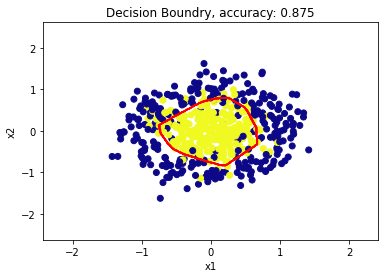

In [5]:
mlp1 = MLP(hidden_layers=[8, 4, 4, 2])
mlp1.fit(X.T, Y, 200)
pred = mlp1.predict(X.T)
acc = accuracy(pred, Y)
plot_decision_boundary(lambda x: mlp1.predict(x.T), X, Y)
plt.title(f"Decision Boundry, accuracy: {acc}")

## 2:
* hidden_layers=[4, 2]
* trained for 200 epochs

epoch 0, loss: 0.24470050087046064, acc: 0.5
epoch 50, loss: 0.14000235262334515, acc: 0.8020833333333334
epoch 100, loss: 0.11599353030421988, acc: 0.8402777777777778
epoch 150, loss: 0.10672457032191973, acc: 0.8559027777777778


Text(0.5, 1.0, 'Decision Boundry, accuracy: 0.8680555555555556')

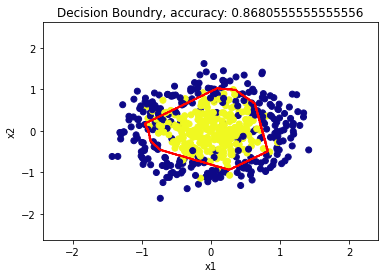

In [6]:
mlp2 = MLP(hidden_layers=[4, 2])
mlp2.fit(X.T, Y, 200)
pred = mlp2.predict(X.T)
acc = accuracy(pred, Y)
plot_decision_boundary(lambda x: mlp2.predict(x.T), X, Y)
plt.title(f"Decision Boundry, accuracy: {acc}")

## 3:
* hidden_layers=[32, 16, 8, 4]
* trained for 200 epochs

epoch 0, loss: 0.26917059270026056, acc: 0.5
epoch 50, loss: 0.09853611978370619, acc: 0.8715277777777778
epoch 100, loss: 0.09205620828552649, acc: 0.8836805555555556
epoch 150, loss: 0.09137015805712134, acc: 0.8836805555555556


Text(0.5, 1.0, 'Decision Boundry, accuracy: 0.8802083333333334')

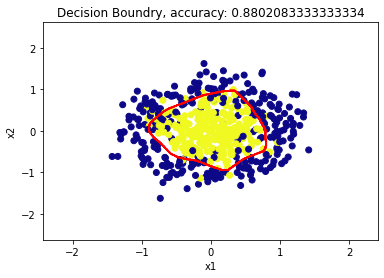

In [7]:
mlp3 = MLP(hidden_layers=[32, 16, 8, 4])
mlp3.fit(X.T, Y, 200)
pred = mlp3.predict(X.T)
acc = accuracy(pred, Y)
plot_decision_boundary(lambda x: mlp3.predict(x.T), X, Y)
plt.title(f"Decision Boundry, accuracy: {acc}")

## 4:
* hidden_layers=[2048]
* trained for 100 epochs

epoch 0, loss: 0.32000748845391425, acc: 0.4895833333333333
epoch 50, loss: 0.4884194924287237, acc: 0.5069444444444444


Text(0.5, 1.0, 'Decision Boundry, accuracy: 0.6180555555555556')

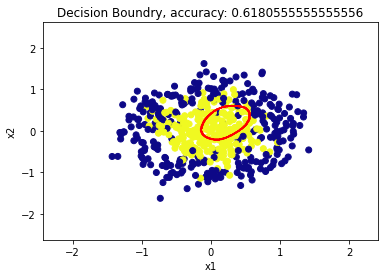

In [11]:
mlp4 = MLP(hidden_layers=[2048])
mlp4.fit(X.T, Y, 100)
pred = mlp4.predict(X.T)
acc = accuracy(pred, Y)
plot_decision_boundary(lambda x: mlp4.predict(x.T), X, Y)
plt.title(f"Decision Boundry, accuracy: {acc}")